# Variational autoencoder for MNIST image generation

Acknowledgment: Some pieces of code are taken from [this notebook](https://github.com/mlelarge/dataflowr/blob/master/CEA_EDF_INRIA/AE_filled_colab.ipynb).

In [1]:
# tested with pytorch 1.2.0 

# import matplotlib
# matplotlib.use('Qt4Agg') # if problem with PyQt5
import os
import matplotlib.pyplot as plt
my_seed = 0
import numpy as np
np.random.seed(my_seed)
import torch
torch.manual_seed(my_seed)
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from utils import to_img, plot_reconstructions_VAE, display_digits
%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


## Loading MNIST

[```torch.utils.data.DataLoader```](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) is an iterator (an object that contains a countable number of values and that can be iterated upon) which provides the following additional features:
- Batching the data (i.e. organizing the training samples in batches);
- Shuffling the data;
- Load the data in parallel using multiprocessing workers.

In addition to the batch size and a boolean indicating if data should be shuffled, it takes as input an instance of [```torch.utils.data.Dataset```](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset), which is an abstract class representing a dataset. This class has the two following methods:
- ```__len__``` which returns the number of samples in the dataset;
- ```__getitem__``` which returns a sample from the dataset given an index.

[```torchvision.datasets```](https://pytorch.org/docs/stable/torchvision/datasets.html) contains various datasets for computer vision which are subclasses of ```torch.utils.data.Dataset```, i.e. they have ```__len__``` and ```__getitem__``` methods implemented. 

In [3]:
if not os.path.exists('data'):
    os.makedirs('data')

train_dataset = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=False, num_workers=1)

test_dataset = datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False, num_workers=1)

In [4]:
# show the properties of the datasets

print(train_dataset)
print('\n')

print(test_dataset)
print('\n')

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()




Image dimension:(1, 28, 28)
Image values between 0.0 and 1.0
Label: 5


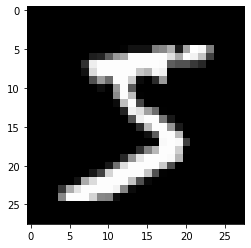

In [5]:
# get the first item in the training set and show properties

item = train_dataset.__getitem__(0) # this is a tuple (tensor, label)
img = item[0].numpy() 
print('Image dimension:%s'% (img.shape,)) # the first dimension is the channel, a color image could have 3 channels (R,G,B)
print('Image values between %.1f and %.1f' % (np.amin(img), np.amax(img)))
label = item[1]
print('Label: %d' % label)
plt.imshow(img[0,:])
plt.gray()

This is everything you need to know for this lab session. If you want to learn more about data loading in PyTorch, you can have a look to [this tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

# Variational autoencoder

Let $\mathbf{x} \in \mathbb{R}^D$ and $\mathbf{z} \in \mathbb{R}^K$ be two random vectors (with $K \ll D$). 

**Generative model**: We consider the following generative model:


$$p(\mathbf{z}) = \mathcal{N}(\mathbf{0}, \mathbf{I})$$

$$p(\mathbf{x} | \mathbf{z} ; \theta ) = \mathcal{N}\left( \boldsymbol{\mu}_\theta(\mathbf{z}), \mathbf{I} \right)$$

The decoder outputs $\boldsymbol{\mu}_\theta(\mathbf{z})$. In theory, the mean of a Gaussian distribution lies in $]- \infty, +\infty[$. However, we know that our data (MNIST images) lie in $[0, 1]^D$, so we expect the mean of $p(\mathbf{x} | \mathbf{z} ; \theta )$ to be in this interval too. This can be enforced by using a sigmoid activation function on the output layer.

**Recognition model**: We consider the following recognition model:

$$q(\mathbf{z} | \mathbf{x}; \phi) = \mathcal{N}\left( \boldsymbol{\mu}_\phi(\mathbf{x}), \text{diag}\left\{ \mathbf{v}_\phi(\mathbf{x}) \right\} \right)$$

The encoder outputs $\boldsymbol{\mu}_\phi(\mathbf{x})$ and $\mathbf{v}_\phi(\mathbf{x})$. A variance has to be positive, so a common practice consists in considering that the network ouputs the logarithm of the variance. You have to properly choose the activation function of the output layer of the encoder based on this information.

In [6]:
class VAE(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(VAE, self).__init__()
        
        self.encoder_fc1 = nn.Linear(input_dim, 512)
        self.encoder_fc2 = nn.Linear(512, 128)
        self.encoder_output_mean = nn.Linear(128, encoding_dim)
        self.encoder_output_log_var = nn.Linear(128, encoding_dim)
        
        self.decoder_fc1 = nn.Linear(encoding_dim, 128)
        self.decoder_fc2 = nn.Linear(128, 512)
        self.decoder_output_mean = nn.Linear(512, input_dim)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def encode(self, x):
        """
        From an input vector (MNIST image), this function computes 
        and returns the mean and log-variance of q(z|x).
        """

        x = self.relu(self.encoder_fc1(x))
        x = self.relu(self.encoder_fc2(x))
        
        return self.encoder_output_mean(x), self.encoder_output_log_var(x)
        
    def decode(self, z):
        """
        From a latent vector, this function computes and returns 
        the mean of p(x|z).
        """

        z = self.relu(self.decoder_fc1(z))
        z = self.relu(self.decoder_fc2(z))
        z = self.sigmoid(self.decoder_output_mean(z)) 
        
        return z    
    
    def reparameterize(self, mu, log_var):
        """
        From the mean and log-variance of q(z|x), this function returns a 
        latent vector drawn from q(z|x) using the reparametrization trick.
        """
        
        ######### TO COMPLETE #########
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        
        return mu + eps * std
        ###############################
    
    def forward(self, x):
        
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_hat = self.decode(z)
        
        return x_hat, mu, log_var

### Exercise 1: Reparameterization

In the forward, between encoding and decoding, we have to sample from the inference model using the reparametrization trick. 

You have to complete the ```reparameterize``` function (it's 3 lines of code). 

You can use the following PyTorch functions: [torch.randn_like](https://pytorch.org/docs/stable/torch.html#torch.randn_like) and [torch.exp](https://pytorch.org/docs/stable/torch.html#torch.exp).

We now instantiate the model using a latent space of dimension 16.

In [19]:
encoding_dim = 16
input_dim = 784 # images of 28 x 28 pixels

model = VAE(input_dim, encoding_dim)

model = model.to(device)

print(model)

VAE(
  (encoder_fc1): Linear(in_features=784, out_features=512, bias=True)
  (encoder_fc2): Linear(in_features=512, out_features=128, bias=True)
  (encoder_output_mean): Linear(in_features=128, out_features=2, bias=True)
  (encoder_output_log_var): Linear(in_features=128, out_features=2, bias=True)
  (decoder_fc1): Linear(in_features=2, out_features=128, bias=True)
  (decoder_fc2): Linear(in_features=128, out_features=512, bias=True)
  (decoder_output_mean): Linear(in_features=512, out_features=784, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


### Exercise 2: Loss function

Complete the following cell to define the loss function. It corresponds to the negative ELBO (refer to the slides), and remember that we set the variance of the generative model to 1.

You have to use:

- [```torch.sum()```](https://pytorch.org/docs/stable/torch.html#torch.sum) which returns the sum of all elements in the input tensor.
- [```torch.exp()```](https://pytorch.org/docs/stable/torch.html#torch.exp) which returns a new tensor with the exponential of the elements of the input tensor.

In [20]:
def VAE_loss(x, x_hat, mu, log_var):
    
    batch_size = x.shape[0]
    
    ############### TO COMPLETE ##############
    reconst_loss = 0.5 * torch.sum( (x_hat - x)**2 ) / batch_size
    regu_loss = - 0.5 * torch.sum( log_var - mu**2 - torch.exp(log_var) ) / batch_size
    return reconst_loss + regu_loss
    ##########################################

### Training

Execute the following cell which implements the training loop to learn the model parameters. You should observe a nice decrease of the loss function.

In [21]:
n_epochs = 10 # number of epochs
learning_rate = 0.001 # learning rate
train_loss = [] # to store the loss after each epoch

# we use Adam, a more sophisticated version of gradient descent
# for an overview of gradient descent algorithms: https://ruder.io/optimizing-gradient-descent/
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.train()

# Main training loop
for epoch in np.arange(n_epochs):

    train_acc_loss = 0 # the loss accumulated (summed) over the mini-batches
    
    print('Epoch: {}'.format(epoch+1))    
    
    for batch_idx, (x, y) in enumerate(train_loader):

        x = x.view([-1, 784]).to(device) # reshape the 28x28 images
        batch_size = x.shape[0]
        
        optimizer.zero_grad() # reset the gradients

        # do forward pass
        x_hat, mu, log_var = model(x)

        # compute loss
        loss = VAE_loss(x, x_hat, mu, log_var)
        
        # do backward pass
        loss.backward()

        # do gradient descent step
        optimizer.step()

        train_acc_loss += loss.item() # accumulate the loss over the training examples
        
        if (batch_idx+1) % 100 == 0:
            print('...loss: {:.6f}'.format(loss.item()))
    
    # store the averaged training loss after each epoch
    train_loss.append(train_acc_loss) 

Epoch: 1
...loss: 28.288383
...loss: 26.183409
...loss: 25.031879
...loss: 26.870369
Epoch: 2
...loss: 24.943985
...loss: 23.256796
...loss: 23.213369
...loss: 24.621164
Epoch: 3
...loss: 24.047913
...loss: 21.991299
...loss: 22.385935
...loss: 23.575077
Epoch: 4
...loss: 23.245686
...loss: 21.545135
...loss: 22.301521
...loss: 23.054728
Epoch: 5
...loss: 23.313105
...loss: 21.357826
...loss: 22.111641
...loss: 22.734226
Epoch: 6
...loss: 23.017612
...loss: 21.043991
...loss: 21.873304
...loss: 22.617756
Epoch: 7
...loss: 22.927103
...loss: 20.864010
...loss: 21.783188
...loss: 22.543354
Epoch: 8
...loss: 23.010740
...loss: 20.540825
...loss: 21.750395
...loss: 22.194290
Epoch: 9
...loss: 22.464033
...loss: 20.623446
...loss: 21.499271
...loss: 22.028404
Epoch: 10
...loss: 22.488455
...loss: 20.470694
...loss: 21.437529
...loss: 21.808437


Text(0.5, 0, 'epochs')

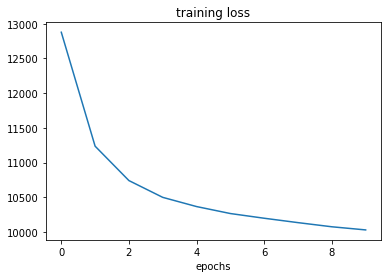

In [22]:
plt.plot(train_loss)
plt.title('training loss')
plt.xlabel('epochs')

### Reconstruction

In the following cell, we take some images from the test dataset and pass them through the VAE in order to observe the quality of reconstructed images, after encoding-decoding.

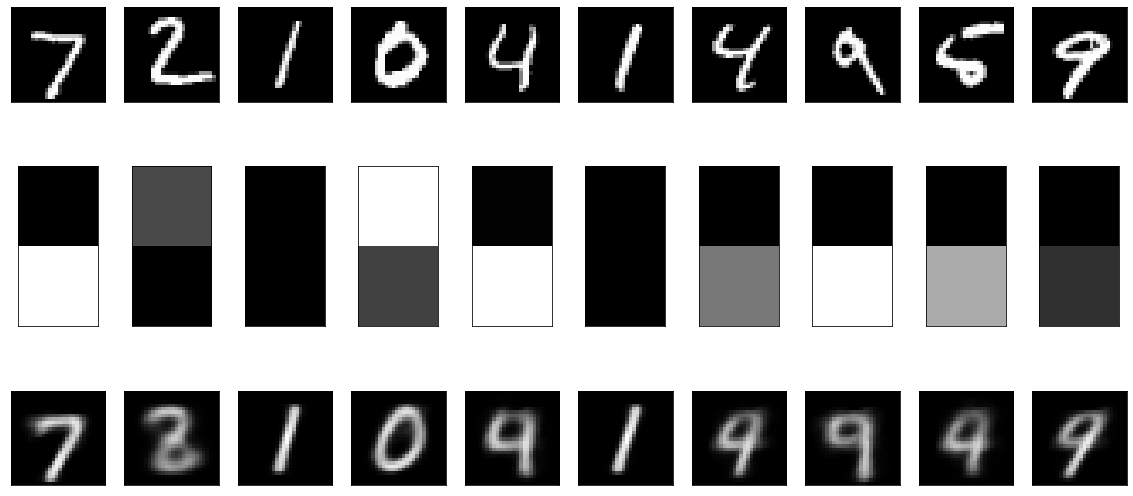

In [23]:
plot_reconstructions_VAE(model, test_loader, device)

## Generation

Let's now generate new images!

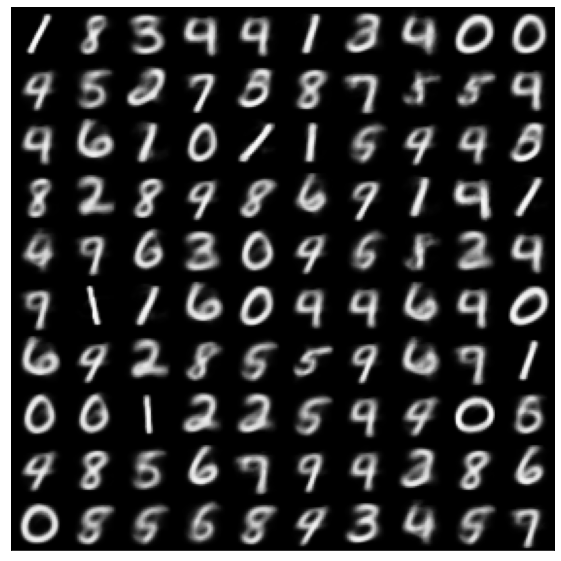

In [24]:
def sample_VAE(model, encoding_dim):
    with torch.no_grad():
        # sample a Gaussian random vector with zero mean and identity covariance matrix
        z = torch.randn(1,encoding_dim).to(device)
        # pass it through the decoder
        x = model.decode(z).reshape(28,28).cpu()
    return x
    
    
n_grid = 10
X_gen = np.zeros((n_grid, n_grid, 28, 28))

for i in range(n_grid):
        for j in range(n_grid):
            X_gen[i,j,:,:] = sample_VAE(model, encoding_dim)
    
display_digits(X_gen, n_i=10, n_j=10, figsize=(10, 10))

### Discussion

You may have observed that the reconstruction quality is not that good (for those of you familar with standard autoencoders, it may seem that the quality is worse). This comes from the fact that the regularization term in the loss function constrains the latent vectors provided by the encoder to be approximately distributed according to a Gaussian distribution with zero mean and identity covariance matrix. Indeed, this term constrains $q(\mathbf{z} | \mathbf{x}; \phi)$ to be not too far from $p(\mathbf{z}) = \mathcal{N}(\mathbf{0}, \mathbf{I})$, according to the KL divergence. This constraint somehow "removes some freedom" from the encoder, which may eventually affect the reconstruction quality. 

If you force the regularization term to be zero (just multiply it by 0 when you compute the loss before the backward), you should recover the reconstruction quality of the autoencoder. However, if you do this you will end up with poor generation results, because at test time (for generating new digits), what you provide to the encoder are samples drawn from $p(\mathbf{z}) = \mathcal{N}(\mathbf{0}, \mathbf{I})$.

To sum up, **there is a trade-off between reconstruction and generation quality**, which comes from the two terms in the loss function. You may try to adjust this trade-off by introducing an hyper-parameter $\beta \ge 0$ multiplying the regularization term in the loss function.



## Walking into the latent space

Let us consider a univariate (i.e. 1D) Gaussian distribution $\mathcal{N}(0, 1)$. We want to build a grid of "equally-spaced" points in this 1-dimensional Gaussian space. For that purpose, we first build a grid of linearly spaced points between 0 and 1, that we then map through the inverse [cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function) (CDF) of the Gaussian. This procedure is illustrated in the following cell. We end up with samples on the x-axis that are distributed according to the target Gaussian distribution. In particular, the density of points increases as we get closer to the mean.

This procedure is related to [inverse transform sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling).

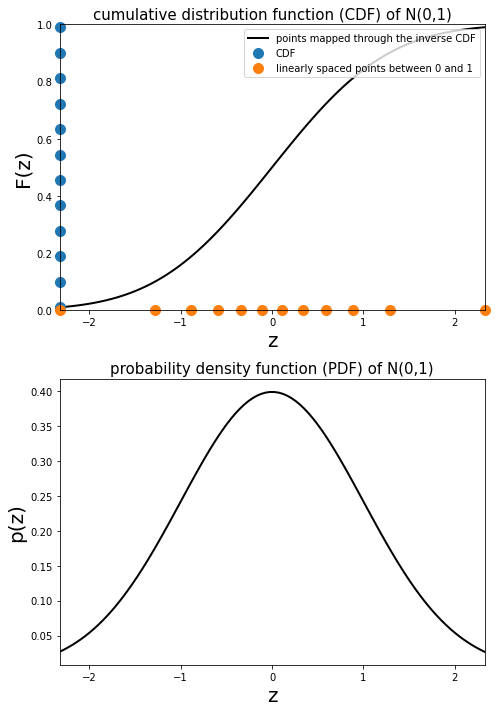

In [25]:
from utils import illust_walk_latent_space

illust_walk_latent_space()

Let's now consider a 2-dimensional latent space, i.e. the latent variable $\mathbf{z} = [z_1, z_2]^\top$ is of dimension $K=2$.

Remember that the prior is $p(\mathbf{z}) = \mathcal{N}(\mathbf{0},\mathbf{I})$, which is equivalent to saying that $z_1$ and $z_2$ are independent and identically distributed (i.i.d) according to $\mathcal{N}(0, 1)$.

Therefore, we can build a grid of "equally-spaced" points in this 2-dimensional Gaussian space by applying the same procedure as before, independently for $z_1$ and $z_2$.

For each pair $(z_1, z_2)$ in this grid, we will map the corresponding vector $\mathbf{z}$ through the trained decoder of the VAE, and show the reconstructed mean image. This will allow us to visualize the learned latent space.

### Exercise 3

We retrain the model with a latent space of dimension 2 and run the following cell.

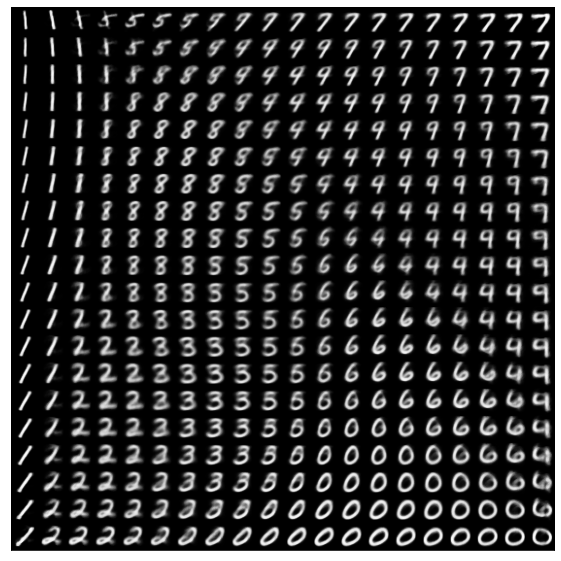

In [27]:
if encoding_dim == 2:
    
    from scipy.stats import norm
    
    n_grid = 20

    uniform_samples = np.linspace(0.01,0.99,n_grid) # linearly spaced points between 0 and 1
    normal_samples = norm.ppf(uniform_samples) # map through inverse CDF
    Z = np.zeros((n_grid, n_grid, encoding_dim))
    X = np.zeros((n_grid, n_grid, 28, 28))

    for i in range(n_grid):
        for j in range(n_grid):
            Z[i,j,0] = normal_samples[i]
            Z[i,j,1] = normal_samples[j]
            with torch.no_grad():
                z_ij_tensor = torch.from_numpy(Z[i,j,:]).reshape(1,encoding_dim).type(torch.FloatTensor).to(device)
                x_gen = model.decode(z_ij_tensor).reshape(28,28)
                X[i,j,:,:] = x_gen.cpu().numpy()

    display_digits(X, figsize=(10, 10))

# Conditional generation (bonus exercise)

So far, we had no control on the class of the generated digit. We do not know if we will generate a 1, or 0, or a 9, etc.

A simple approach to be able to control this aspect of the generation consits in modifying the model as follows:

Let $\mathbf{x} \in \mathbb{R}^D$ and $\mathbf{z} \in \mathbb{R}^K$ be two random vectors. Let $\mathbf{y} \in \{0,1\}^C$ be a one-hot encoding vector representing the class label (in our case, $C=10$).

We now consider the following generative model conditioned on the class label:

$$p(\mathbf{z}) = \mathcal{N}(\mathbf{0}, \mathbf{I})$$

$$p(\mathbf{x} | \mathbf{z}, \mathbf{y} ; \theta ) = \mathcal{N}\left( \boldsymbol{\mu}_\theta(\mathbf{z}, \mathbf{y}), \mathbf{I} \right)$$


and the following recognition model:

$$q(\mathbf{z} | \mathbf{x}, \mathbf{y}; \phi) = \mathcal{N}\left( \boldsymbol{\mu}_\phi(\mathbf{x}, \mathbf{y}),  \text{diag}\left\{ \mathbf{v}_\phi(\mathbf{x}, \mathbf{y}) \right\}  \right)$$

You can define a new class ``CVAE`` where the encoder and decoder will now also take as input this one-hot encoding vector. Just use the following function to concatenate two tensors:

``torch.cat([x, y], dim=1))`` 

In [15]:
class CVAE(nn.Module):
    def __init__(self, input_dim, encoding_dim, cat_dim):
        
        super(CVAE, self).__init__()
        
        ################## TO DO ##################
        self.encoder_fc1 = nn.Linear(input_dim + cat_dim, 512)
        self.encoder_fc2 = nn.Linear(512, 128)
        self.encoder_output_mean = nn.Linear(128, encoding_dim)
        self.encoder_output_log_var = nn.Linear(128, encoding_dim)
        
        self.decoder_fc1 = nn.Linear(encoding_dim + cat_dim, 128)
        self.decoder_fc2 = nn.Linear(128, 512)
        self.decoder_output_mean = nn.Linear(512, input_dim)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        ##########################################
        
    def encode(self, x, y):
        ################## TO DO ##################
        x = self.relu(self.encoder_fc1(torch.cat([x, y], dim=1)))
        x = self.relu(self.encoder_fc2(x))
        return self.encoder_output_mean(x), self.encoder_output_log_var(x)
        ##########################################
    
    def reparameterize(self, mu, log_var):
        ################## TO DO ##################
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std
        ##########################################
    
    def decode(self, z, y):
        ################## TO DO ##################
        z = self.relu(self.decoder_fc1(torch.cat([z, y], dim=1)))
        z = self.relu(self.decoder_fc2(z))
        z = self.sigmoid(self.decoder_output_mean(z)) 
        return z
        ##########################################
        
    def forward(self, x, y):
        mu, log_var = self.encode(x, y)
        z = self.reparameterize(mu, log_var)
        x_hat = self.decode(z, y)
        return x_hat, mu, log_var

We instantiate the model:

In [16]:
encoding_dim = 16
input_dim = 784 # images of 28 x 28 pixels
cat_dim = 10 # one hot vectors for 10 classes

model = CVAE(input_dim, encoding_dim, cat_dim)

model = model.to(device)

Complete the following cell to train the model. It is very similar to the above VAE training, except that we now use both the images and labels provided by ```train_loader```.

In [17]:
num_classes = 10 # number of digit classes
n_epochs = 5 # number of epochs
learning_rate = 0.001 # learning rate
train_loss = [] # to store the loss after each epoch

# we use Adam, a more sophisticated version of gradient descent
# for an overview of gradient descent algorithms: https://ruder.io/optimizing-gradient-descent/
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.train()

# Main training loop
for epoch in np.arange(n_epochs):
    
    train_acc_loss = 0 # the loss accumulated (summed) over the mini-batches
    
    print('Epoch: {}'.format(epoch+1))    

    for batch_idx, (x, y) in enumerate(train_loader):

        x = x.view([-1, 784]).to(device) # reshape the 28x28 images
        y = nn.functional.one_hot(y, num_classes=num_classes).type(torch.FloatTensor).to(device)
        
        ################## TO DO ##################
        
        model.zero_grad() # reset the gradients

        # do forward pass
        x_hat, mu, log_var = model(x, y)

        # compute loss
        reconst_loss = 0.5 * torch.sum( (x_hat - x)**2 ) / batch_size
        regu_loss = - 0.5 * torch.sum( log_var - mu**2 - torch.exp(log_var) ) / batch_size
        loss = reconst_loss + regu_loss
        
        # do backward pass
        loss.backward()

        # do gradient descent step
        optimizer.step()

        train_acc_loss += loss.item() # accumulate the loss over the training examples
        
        if (batch_idx+1) % 100 == 0:
            print('...loss: {:.6f}'.format(loss.item()))
    
    # store the averaged training loss after each epoch
    train_loss.append(train_acc_loss) 
    
        ##########################################

Epoch: 1
...loss: 45.137711
...loss: 38.832279
...loss: 39.010597
...loss: 40.165993
Epoch: 2
...loss: 38.835857
...loss: 35.110710
...loss: 35.687775
...loss: 36.568844
Epoch: 3
...loss: 36.546425
...loss: 33.432373
...loss: 34.691048
...loss: 34.816711
Epoch: 4
...loss: 35.535748
...loss: 32.619545
...loss: 33.892387
...loss: 33.515553
Epoch: 5
...loss: 34.715149
...loss: 31.963028
...loss: 33.592255
...loss: 33.082432


Let's now sample new data, conditionnally on the class of digit!

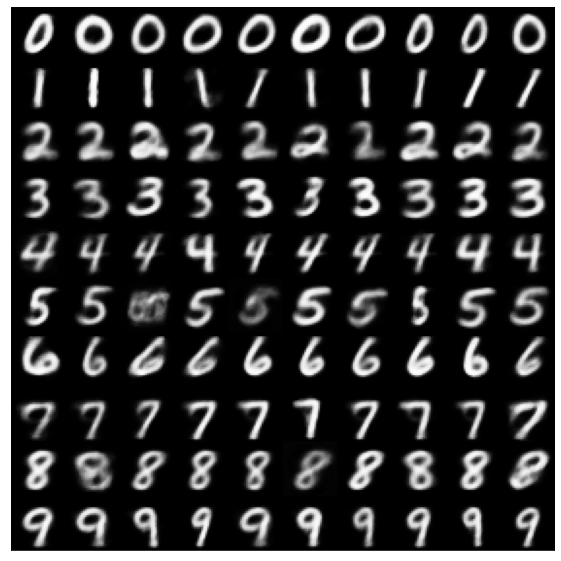

In [18]:
n_grid = 10
X_gen = np.zeros((n_grid, n_grid, 28, 28))

def sample_CVAE(model, encoding_dim, class_ind=0):
    with torch.no_grad():
        z = torch.randn(1,encoding_dim).type(torch.FloatTensor).to(device)
        y = torch.tensor([class_ind]).type(torch.int64).to(device)
        y_one_hot = nn.functional.one_hot(y, num_classes=10).type(torch.FloatTensor).to(device)
        x = model.decode(z, y_one_hot).reshape(28,28).cpu()
    return x
    

for i in range(n_grid):
        for j in range(n_grid):
            with torch.no_grad():
                z = torch.randn(1,encoding_dim).type(torch.FloatTensor).to(device)
                y = torch.tensor([i]).type(torch.int64).to(device)
                y_one_hot = nn.functional.one_hot(y, num_classes=10).type(torch.FloatTensor).to(device)
                X_gen[i,j,:,:] = sample_CVAE(model, encoding_dim,i)
    
display_digits(X_gen, n_i=10, n_j=10, figsize=(10, 10))